In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/alpha_clf.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 10

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

62 - accuracy: 0.8346 - val_loss: 0.1050 - val_accuracy: 0.9962

Epoch 00384: saving model to model/keypoint_classifier\alpha_clf.hdf5
Epoch 385/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4459 - accuracy: 0.8224 - val_loss: 0.1073 - val_accuracy: 0.9962

Epoch 00385: saving model to model/keypoint_classifier\alpha_clf.hdf5
Epoch 386/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4056 - accuracy: 0.8408 - val_loss: 0.1071 - val_accuracy: 0.9962

Epoch 00386: saving model to model/keypoint_classifier\alpha_clf.hdf5
Epoch 387/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.4613 - accuracy: 0.8314 - val_loss: 0.1067 - val_accuracy: 0.9962

Epoch 00387: saving model to model/keypoint_classifier\alpha_clf.hdf5
Epoch 388/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.4343 - accuracy: 0.8434 - val_loss: 0.1047 - val_accuracy: 0.9962

Epoch 00388: saving model to model/keypoint_classifier\alpha_clf.hdf5
Epoch 389/100

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 2ms/step - loss: 0.0825 - accuracy: 0.9962


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[5.3620241e-03 2.7696416e-02 1.1401556e-02 3.7206011e-08 1.5422781e-03
 9.5399624e-01 2.8878120e-09 1.5834539e-08 3.2841407e-07 1.1933142e-06]
5


# 混同行列

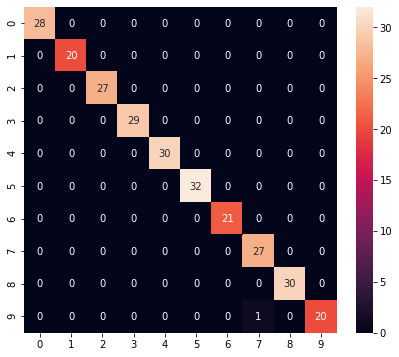

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        27
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        32
           6       1.00      1.00      1.00        21
           7       0.96      1.00      0.98        27
           8       1.00      1.00      1.00        30
           9       1.00      0.95      0.98        21

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/alpha_clf.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\LAPTOP~1\AppData\Local\Temp\tmpx3i8ehhq\assets


6624

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 1.01 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.3620315e-03 2.7696444e-02 1.1401567e-02 3.7206153e-08 1.5422809e-03
 9.5399624e-01 2.8878175e-09 1.5834569e-08 3.2841501e-07 1.1933176e-06]
5
